# Classification and Regression Diffusion Model (CARD)

## Theoretic Foundation

### Conditional Diffusion Models

### Training Procedure


### Pros and Cons of these Models 



## Imports

In [1]:
import os
import sys
import torch

import tempfile
from functools import partial

import matplotlib.pyplot as plt
import torch.nn as nn
from lightning import Trainer
from lightning.pytorch import seed_everything
from lightning.pytorch.loggers import CSVLogger
from torch.optim import Adam

from lightning_uq_box.datamodules import ToyHeteroscedasticDatamodule
from lightning_uq_box.models import MLP, ConditionalGuidedLinearModel
from lightning_uq_box.uq_methods import CARDModel, BaseModel
from lightning_uq_box.viz_utils import (
    plot_calibration_uq_toolbox,
    plot_predictions,
    plot_toy_data,
    plot_training_metrics,
)

plt.rcParams["figure.figsize"] = [14, 5]

/home/nils/.conda/envs/uqboxEnv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
seed_everything(0)  # seed everything for reproducibility

Global seed set to 0


0

In [3]:
my_temp_dir = tempfile.mkdtemp()

## Datamodule

In [4]:
dm = ToyHeteroscedasticDatamodule(n_train=1000)

X_train, y_train, train_loader, X_test, y_test, test_loader = (
    dm.X_train,
    dm.y_train,
    dm.train_dataloader(),
    dm.X_test,
    dm.y_test,
    dm.test_dataloader(),
)

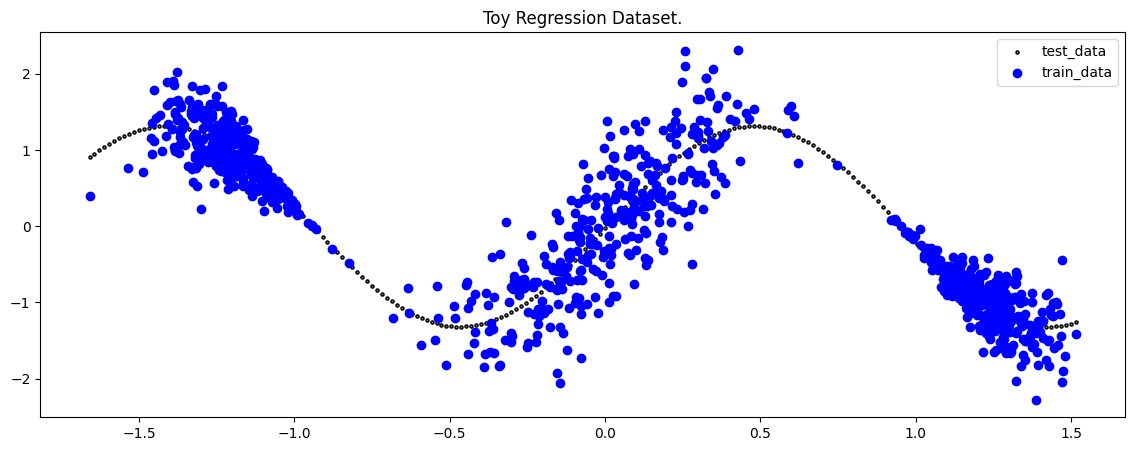

In [5]:
plot_toy_data(X_train, y_train, X_test, y_test)

## Model

For CARD, we need to pretrain a conditional mean estimation model before moving to diffusion training stage. Here, we will do this with a simple MLP and train it using the `BaseModel Class` with lightning.

In [6]:
network = MLP(n_inputs=1, n_hidden=[50, 50], n_outputs=1)

cond_mean_model = BaseModel(
    model=network,
    optimizer=partial(torch.optim.Adam, lr=1e-2),
    loss_fn=nn.MSELoss()
)

trainer = Trainer(
    max_epochs=100,  # number of epochs we want to train
    accelerator="cpu",
    enable_checkpointing=False,
    enable_progress_bar=False,
)
trainer.fit(cond_mean_model, dm)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/nils/.local/lib/python3.9/site-packages/lightning/pytorch/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=8)`.
  rank_zero_warn(

  | Name          | Type             | Params
---------------------------------------------------
0 | train_metrics | MetricCollection | 0     
1 | val_metrics   | MetricCollection | 0     
2 | test_metrics  | MetricCollection | 0     
3 | model         | MLP              | 2.7 K 
4 | loss_fn       | MSELoss          | 0     
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
/home/nils/.local/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442

We can plot the predictions of the pretrained model, which as a deterministic point network has no uncertainty estimate for its predictions. 

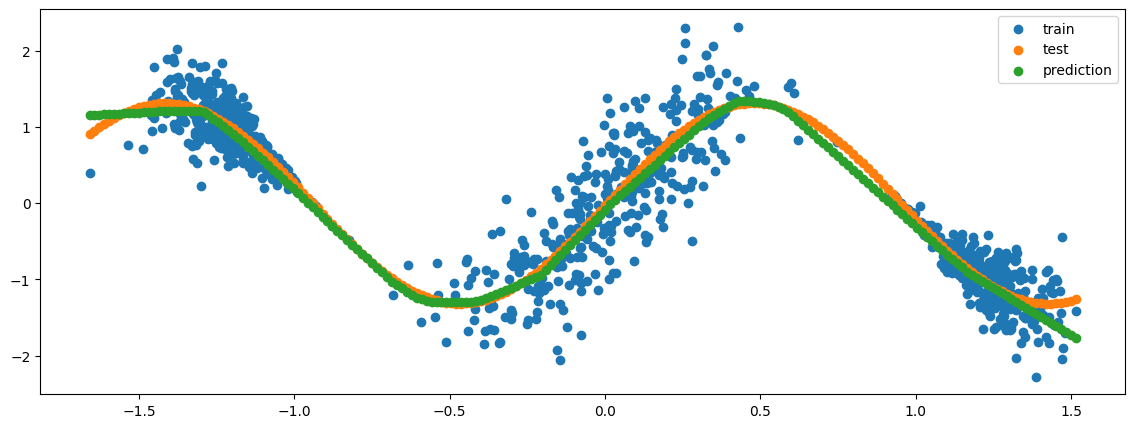

In [7]:
preds = cond_mean_model.predict_step(X_test)
fig, ax = plt.subplots(1)
ax.scatter(X_train, y_train, label="train")
ax.scatter(X_test, y_test, label="test")
ax.scatter(X_test, preds["pred"], label="prediction")
plt.legend()

## Diffusion Model

Given the deterministic conditional mean model, we can now move towards the diffusion modelling stage. For the guidance model we also select a simple Linear model.

In [8]:
# configuration parameters

n_steps = 1000
cat_x = True
cat_y_pred = True

x_dim = 1
y_dim = 1
z_dim = 2

n_hidden = [128, 128]

In [9]:
guidance_model = ConditionalGuidedLinearModel(
    n_steps=n_steps,
    x_dim=x_dim,
    y_dim=y_dim,
    z_dim=z_dim,
    n_hidden=n_hidden,
    cat_x=cat_x,
    cat_y_pred=cat_y_pred,
)

With these elements we can now instantiate our Lightning Module to conduct the Diffusion training.

In [10]:
card_model = CARDModel(
    cond_mean_model=cond_mean_model.model,
    guidance_model=guidance_model,
    guidance_optim=partial(torch.optim.Adam, lr=1e-2),
    n_steps=n_steps,
)

In [11]:
logger = CSVLogger(my_temp_dir)
diff_trainer = Trainer(
    max_epochs=1000,  # number of epochs we want to train
    accelerator="gpu",
    devices=[0],
    logger=logger,
    log_every_n_steps=10,
    enable_checkpointing=False,
    enable_progress_bar=False,
)
diff_trainer.fit(card_model, dm)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A6000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name            | Type                         | Params
-----------------------------------------------------------------
0 | cond_mean_model | MLP                          | 2.7 K 
1 | guidance_model  | ConditionalGuidedLinearModel | 273 K 
2 | train_metrics   | MetricCollection             | 0     
3 | val_metrics     | MetricCollection             | 0     
4 | test_metrics    | MetricCollection             | 0     
--------

## Training Metrics

Check convergence.

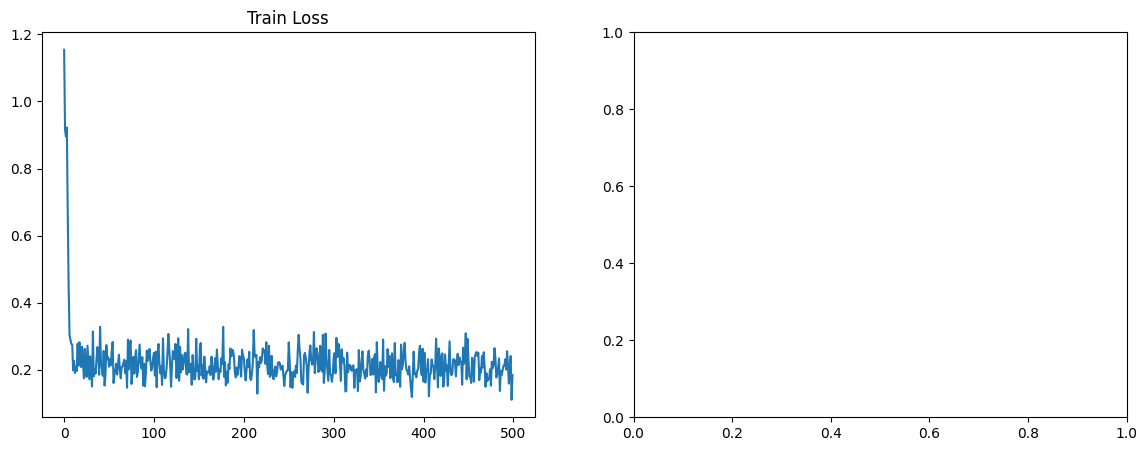

In [12]:
fig = plot_training_metrics(my_temp_dir)

## Prediction

For prediction we can either rely on the `trainer.test()` method or manually conduct a `predict_step()`. Using the trainer will save the predictions and some metrics to a CSV file. For the Diffusion Inference procedure, this will happen ...

In [13]:
preds = card_model.predict_step(X_test)

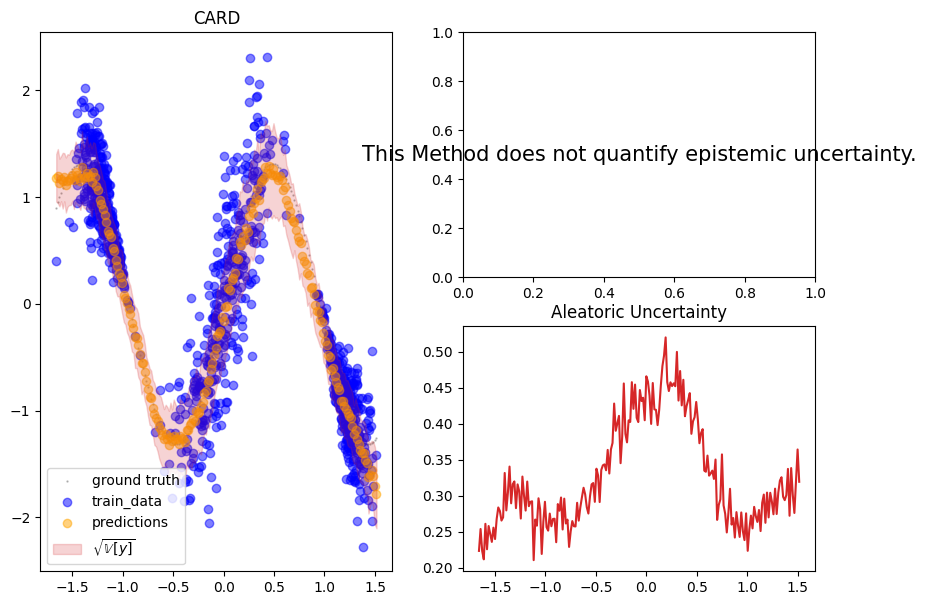

In [14]:
fig = plot_predictions(
    X_train,
    y_train,
    X_test,
    y_test,
    preds["pred"],
    preds["pred_uct"],
    aleatoric=preds["aleatoric_uct"],
    title="CARD",
    show_bands=False,
)